<a href="https://colab.research.google.com/github/tkahng/trkml/blob/master/colab/Document_Parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Document Parsing API Notebook

*Copyright 2019 Google LLC. This software is provided as-is, without warranty or representation for any use or purpose. 
Your use of it is subject to your agreements with Google.*

This notebook demos how to use document parsing API to parse PDF or TIFF documents into structured output, and how to visualize the outputs. For detailed documentation, please refer to the following links:

[Table Parsing](https://cloud.google.com/vision/alpha/docs/table-parsing)

[Key/value pairs Parsing](https://cloud.google.com/vision/alpha/docs/key-value-pair)

You need to be *whitelisted* the use vision API alpha features. Please contact smoturu@google.com for whitelisting if you do not have access.


## Install Dependencies
We'll start by authenticating to GCS and creating the service client.

In [ ]:
import sys
from google.cloud import storage
from google.cloud import vision_v1 as vision
from google.protobuf import json_format
from google.colab import auth
auth.authenticate_user()

In [ ]:
%%capture
!pip install https://storage.googleapis.com/api-client-staging/vision-python-q1alpha-mar2019.tar.gz

Set up the service account. 

Please follow the instruction here to create a service acccount, and paste the content of the service account json file to the following code.

[Authentication](https://cloud.google.com/vision/alpha/docs/auth)

In [ ]:
service_account_str = r"""
PASTE YOUR SERVICE ACCOUNT STRING HERE.
"""

with open('./service_account.json', 'w') as f:
  f.write(service_account_str)


### Define table and key/value parsing functions and utility function.

In [ ]:
import os
import re
from IPython.display import display, HTML, Image
import numpy as np
from IPython.display import Image as DisplayImage
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import matplotlib.pyplot as plt
import matplotlib


import tensorflow as tf

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./service_account.json"


def async_detect_table(gcs_source_uri, gcs_destination_uri, doc_type='tiff'):
  """Table Detection with PDF/TIFF as source files on Google Cloud Storage."""

  if doc_type == 'tiff':
    mime_type = 'image/tiff'
  else:
    mime_type = 'application/pdf'

  print(os.environ["GOOGLE_APPLICATION_CREDENTIALS"])

  # How many pages should be grouped into each json output file.
  batch_size = 2
  client = vision.ImageAnnotatorClient()
  feature = vision.types.Feature(
      type=vision.enums.Feature.Type.DOCUMENT_PARSING)
  gcs_source = vision.types.GcsSource(uri=gcs_source_uri)
  input_config = vision.types.InputConfig(
      gcs_source=gcs_source, mime_type=mime_type)
  gcs_destination = vision.types.GcsDestination(uri=gcs_destination_uri)
  output_config = vision.types.OutputConfig(
      gcs_destination=gcs_destination, batch_size=batch_size)

  # Provide the bounding box (with normalized vertices in [0, 1]) for the table.
  # If not provided, the system will attempt to detect tables on the page. It
  # is recommended to provide the box for best accuracy.
  vertex = vision.types.NormalizedVertex
  table_bounding_box = vision.types.BoundingPoly(normalized_vertices=[
      vertex(x=0, y=0),
      vertex(x=1, y=0),
      vertex(x=1, y=1),
      vertex(x=0, y=1)
  ])

  # The table bound hint is by default applied to all pages, but the page_number
  # parameter can be given to apply it to specific pages.
  table_bound_hint = vision.types.TableBoundHint(
      bounding_box=table_bounding_box)

  table_detection_options = vision.types.TableDetectionOptions(
      table_bound_hints=[table_bound_hint])
  text_detection_params = vision.types.DocumentParsingParams(
      table_detection_options=table_detection_options)
  image_context = vision.types.ImageContext(
      document_parsing_params=text_detection_params)

  async_request = vision.types.AsyncAnnotateFileRequest(
      features=[feature],
      input_config=input_config,
      output_config=output_config,
      image_context=image_context)

  operation = client.async_batch_annotate_files(requests=[async_request])

  print('Waiting for the operation to finish.')
  operation.result(timeout=10000)

  # Once the request has completed and the output has been
  # written to Google Cloud Storage, we can list all the output files.
  storage_client = storage.Client()

  match = re.match(r'gs://([^/]+)/(.+)', gcs_destination_uri)
  bucket_name = match.group(1)
  prefix = match.group(2)

  bucket = storage_client.get_bucket(bucket_name=bucket_name)

  # List objects with the given prefix.
  blob_list = list(bucket.list_blobs(prefix=prefix))
  print('Output files:')
  for blob in blob_list:
    print(blob.name)

  # Process the first output file from Google Cloud Storage.
  # Since we specified batch_size=2, the first response contains
  # the first two pages of the input file.
  output = blob_list[0]

  json_string = output.download_as_string()
  response = json_format.Parse(json_string, vision.types.AnnotateFileResponse())

  # The actual response for the first page of the input file.
  first_page_response = response.responses[0]
  annotation = first_page_response.full_text_annotation

  # Print out all detected tables
  for page in annotation.pages:
    for block in page.blocks:
      # 2 is the enum value for TABLE
      if block.block_type == vision.enums.Block.BlockType.TABLE:
        print(u'Table:\n{}'.format(block))
  return response


# Convert table to HTML.
def convert_block_to_html(block):
  html_text = "<table>\n"  
  for row in block.table.header_rows:
    html_text += "<tr>\n"
    for cell in row.cells:
      html_text += "<th> %s </th>" % cell.text
    html_text += "</tr>\n"        
  for row in block.table.body_rows:
    html_text += "<tr>\n"
    for cell in row.cells:
      html_text += "<td> %s </td>" % cell.text
    html_text += "</tr>\n"      
  html_text += "</table>\n"
  return html_text

def convert_response_to_html(response):
  first_page_response = response.responses[0]
  annotation = first_page_response.full_text_annotation
  output_html = r"""
  <head>
  <style>
    table, th, td {
      border: 1px solid black;
    }
  </style>
  </head>
  """
  for i, page in enumerate(annotation.pages):
    output_html += "<h1> Page %d </h1>\n" %  i
    if page.blocks:          
      for block in page.blocks:
        # 2 is the enum value for TABLE
        if block.block_type == vision.enums.Block.BlockType.TABLE:
          output_html += convert_block_to_html(block)
  return output_html      

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.

  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.

  Each string in display_str_list is displayed on a separate line above the
  bounding box in black text on a rectangle filled with the input 'color'.
  If the top of the bounding box extends to the edge of the image, the strings
  are displayed below the bounding box.

  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  try:
    font = ImageFont.truetype('arial.ttf', 24)
  except IOError:
    font = ImageFont.load_default()

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
        fill=color)
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
    text_bottom -= text_height - 2 * margin

def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color='red',
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
  """Adds a bounding box to an image (numpy array).

  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.

  Args:
    image: a numpy array with shape [height, width, 3].
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
  draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                             thickness, display_str_list,
                             use_normalized_coordinates)
  np.copyto(image, np.array(image_pil))


def draw_block_to_image(image, block):
  for row in block.table.header_rows:
    for cell in row.cells:
      xmin = cell.text_block.bounding_box.normalized_vertices[0].x
      ymin = cell.text_block.bounding_box.normalized_vertices[0].y
      xmax = cell.text_block.bounding_box.normalized_vertices[2].x
      ymax = cell.text_block.bounding_box.normalized_vertices[2].y
      draw_bounding_box_on_image_array(image, ymin, xmin, ymax, xmax, thickness=2)      
  for row in block.table.body_rows:
    for cell in row.cells:
      xmin = cell.text_block.bounding_box.normalized_vertices[0].x
      ymin = cell.text_block.bounding_box.normalized_vertices[0].y
      xmax = cell.text_block.bounding_box.normalized_vertices[2].x
      ymax = cell.text_block.bounding_box.normalized_vertices[2].y
      draw_bounding_box_on_image_array(image, ymin, xmin, ymax, xmax, color='blue', thickness=2)  

def draw_response_to_image(image, response):
  # Print out all detected tables
  first_page_response = response.responses[0]
  annotation = first_page_response.full_text_annotation
  for i, page in enumerate(annotation.pages):
    assert (i == 0)
    if page.blocks:          
      for block in page.blocks:
        # 2 is the enum value for TABLE
        if block.block_type == vision.enums.Block.BlockType.TABLE:
          draw_block_to_image(image, block)    

def async_detect_key_value_pairs(gcs_source_uri, document_type, gcs_destination_uri, doc_type='tiff'):
  """Key Value Pair Detection with PDF/TIFF as source files on Google Cloud Storage with specific
  document type.

  Args:
  gcs_source_uri: Google Cloud Storage Source URI for detection.
  document_type: Type of the document. e.g. INVOICE, GENERAL
  gcs_destination_uri: Destination URI for output.
  """
  # Please use application/pdf if you want to parse PDF files.
  if doc_type == 'tiff':
    mime_type = 'image/tiff'
  else:
    mime_type = 'application/pdf'

  # How many pages should be grouped into each json output file.
  batch_size = 2

  client = vision.ImageAnnotatorClient()

  feature = vision.types.Feature(
      type=vision.enums.Feature.Type.DOCUMENT_PARSING)

  gcs_source = vision.types.GcsSource(uri=gcs_source_uri)
  input_config = vision.types.InputConfig(
      gcs_source=gcs_source, mime_type=mime_type)

  gcs_destination = vision.types.GcsDestination(uri=gcs_destination_uri)
  output_config = vision.types.OutputConfig(
      gcs_destination=gcs_destination, batch_size=batch_size)

  # Set a document type here. If no document type is set, the system will treat
  # it as GENERAL form.
  document_parsing_params = vision.types.DocumentParsingParams(
      document_type=document_type)
  image_context = vision.types.ImageContext(
      document_parsing_params=document_parsing_params)

  async_request = vision.types.AsyncAnnotateFileRequest(
      features=[feature],
      input_config=input_config,
      output_config=output_config,
      image_context=image_context)

  operation = client.async_batch_annotate_files(requests=[async_request])

  print('Waiting for the operation to finish.')
  operation.result(timeout=10000)

  # Once the request has completed and the output has been
  # written to Google Cloud Storage, we can list all the output files.
  storage_client = storage.Client()

  match = re.match(r'gs://([^/]+)/(.+)', gcs_destination_uri)
  bucket_name = match.group(1)
  prefix = match.group(2)

  bucket = storage_client.get_bucket(bucket_name=bucket_name)

  # List objects with the given prefix.
  blob_list = list(bucket.list_blobs(prefix=prefix))
  print('Output files:')
  for blob in blob_list:
    print(blob.name)

  # Process the first output file from Google Cloud Storage.
  # Since we specified batch_size=2, the first response contains
  # the first two pages of the input file.
  output = blob_list[0]

  json_string = output.download_as_string()
  response = json_format.Parse(json_string, vision.types.AnnotateFileResponse())

  # The actual response for the first page of the input file.
  first_page_response = response.responses[0]
  annotation = first_page_response.full_text_annotation

  # Print out all detected key value pairs.
  for page in annotation.pages:
    for block in page.blocks:
      # 6 is the enum value for Key Value Pair
      if block.block_type == vision.enums.Block.BlockType.KEY_VALUE_PAIR:
        print(u'Key value pair:\n{}'.format(block))
  return response

# Convert  key/value pairs to HTML.
def convert_form_block_to_html(block):
  html_text = "<b> Key </b>: %s \n" % block.key_value_pair.key_block.merged_text
  html_text += "<b> Value </b>: %s </br> </br>\n" % block.key_value_pair.value_block.merged_text
  return html_text

def convert_form_response_to_html(response):
  first_page_response = response.responses[0]
  annotation = first_page_response.full_text_annotation
  output_html = r"""
  <head>
  </head>
  """
  for i, page in enumerate(annotation.pages):
    output_html += "<h1> Page %d </h1>\n" %  i
    if page.blocks:          
      for block in page.blocks:
        if block.block_type == vision.enums.Block.BlockType.KEY_VALUE_PAIR:
          output_html += convert_block_to_html(block)
  return output_html

def extract_box_coordinates(bounding_box):
  return (bounding_box.normalized_vertices[0].x, 
  bounding_box.normalized_vertices[0].y,
  bounding_box.normalized_vertices[2].x,
  bounding_box.normalized_vertices[2].y
  )
def draw_from_block_to_image(image, block):
    xmin, ymin, xmax, ymax = extract_box_coordinates(block.bounding_box)
    draw_bounding_box_on_image_array(image, ymin, xmin, ymax, xmax, color='green', thickness=2)    
    xmin, ymin, xmax, ymax = extract_box_coordinates(block.key_value_pair.key_block.bounding_box)
    draw_bounding_box_on_image_array(image, ymin, xmin, ymax, xmax, color='blue', thickness=2)  
    xmin, ymin, xmax, ymax = extract_box_coordinates(block.key_value_pair.value_block.bounding_box)
    draw_bounding_box_on_image_array(image, ymin, xmin, ymax, xmax, color='red', thickness=2)        

def draw_form_response_to_image(image, response):
  # Print out all detected tables
  first_page_response = response.responses[0]
  annotation = first_page_response.full_text_annotation
  for i, page in enumerate(annotation.pages):
    assert (i == 0)
    if page.blocks:          
      for block in page.blocks:
        # 2 is the enum value for TABLE
        if block.block_type == vision.enums.Block.BlockType.KEY_VALUE_PAIR:
          draw_from_block_to_image(image, block)      

## Run Table Parsing and Visualization

In [ ]:
input_path = 'gs://document_parsing_example/table.tiff'
output_path = 'gs://document_parsing_example/table_output.json'
response = async_detect_table(input_path, output_path)

input_pdf_path = 'gs://document_parsing_example/table.pdf'
output_pdf_path = 'gs://document_parsing_example/table_pdf_output.json'
response_pdf = async_detect_table(input_pdf_path, output_pdf_path, 'pdf')


./service_account.json
Waiting for the operation to finish.
Output files:
table_output.jsonoutput-1-to-1.json
Table:
bounding_box {
  normalized_vertices {
  }
  normalized_vertices {
    x: 1.0
  }
  normalized_vertices {
    x: 1.0
    y: 1.0
  }
  normalized_vertices {
    y: 1.0
  }
}
block_type: TABLE
confidence: 1.0
table {
  header_rows {
    cells {
      row_span: 1
      col_span: 1
      text_block {
        bounding_box {
          normalized_vertices {
          }
          normalized_vertices {
            x: 0.26132404804229736
          }
          normalized_vertices {
            x: 0.26132404804229736
            y: 0.125
          }
          normalized_vertices {
            y: 0.125
          }
        }
      }
    }
    cells {
      row_span: 1
      col_span: 1
      text_block {
        bounding_box {
          normalized_vertices {
            x: 0.26132404804229736
          }
          normalized_vertices {
            x: 0.40419119596481323
          }
  

In [ ]:
# Visualize Table to HTML.
html_text = convert_response_to_html(response)
display(HTML(html_text))

html_text = convert_response_to_html(response_pdf)
display(HTML(html_text))


,Community,Courses - Bath Autumn 1997,,
Course Name,Course Tutor,Sumary,Code,Fee
After the Civil War,Dr. John Wroughton,The course will examine the turhulent years in England after 1646. 6 weekly meetings startingMonday 13th October.,H27,£32
An Introduction to Anglo-Saxon England,Mark Cottle,One day course introducing the early medieval period reconstruction the Anglo-Saxons and their society. Saturday 18th October,H28,£18
The Glory that was Greece,Valerie Lorenz,"Birthplace of democracy, philosophy, heartland of theater, home of argument. The Romans may have done it but the Greeks did it first. Sotuday day school 25th October 1997",H30,£18


,Community,Courses --Bath Autumn 1997,,
Course Name,Course Tutor,Summary,Code,Fee
After the Civil War,Dr. John Wroughton,The course will examine the turbulent years in England after 1646. 6 weekly meetings stoarting Monday 13th October.,H27,£32
An Introduction to Anglo-Saxon England,Mark Cottle,One day course introducing the early medieval period reconstruction the Anglo-Saxons and their society. Saturday 18th October,H28,£18
The Glory that was Greece,Valerie Lorenz,"Birthplace of democracy, philosophy, heartland of theater, home of argument. The Romans may have done it but the Greeks did it first. Soturday day school 25th October 1997",H30,£18


(280, 574, 3)


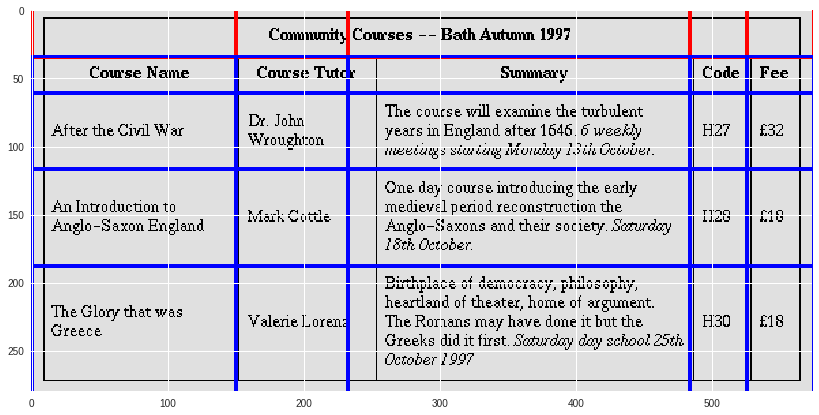

In [ ]:
# Visualize table to images. It only support visualizing TIFF input now.
with tf.gfile.Open(input_path, 'rb') as fid:
  img_data = Image.open(fid)

img = np.array(img_data.convert("RGB"))
draw_response_to_image(img, response)
print(img.shape)
plt.rcParams['figure.figsize'] = [14, 14]
plt.imshow(img)
plt.show()




## Run Form Parsing and Visualization

In [ ]:
input_form_path = 'gs://document_parsing_example/invoice.tiff'
output_form_path = 'gs://document_parsing_example/invoice_output.json'
response_form = async_detect_key_value_pairs(input_form_path, 'GENERAL', output_path)
input_form_pdf_path = 'gs://document_parsing_example/invoice.pdf'
output_form_pdf_path = 'gs://document_parsing_example/invoice_pdf_output.json'
response_form_pdf = async_detect_key_value_pairs(input_form_pdf_path, 'GENERAL', output_form_pdf_path, 'pdf')

In [ ]:
# Visualize key/value pairs to HTML.
html_text = convert_form_response_to_html(response_form)
display(HTML(html_text))

html_text = convert_form_response_to_html(response_form_pdf)
display(HTML(html_text))

(674, 478, 3)


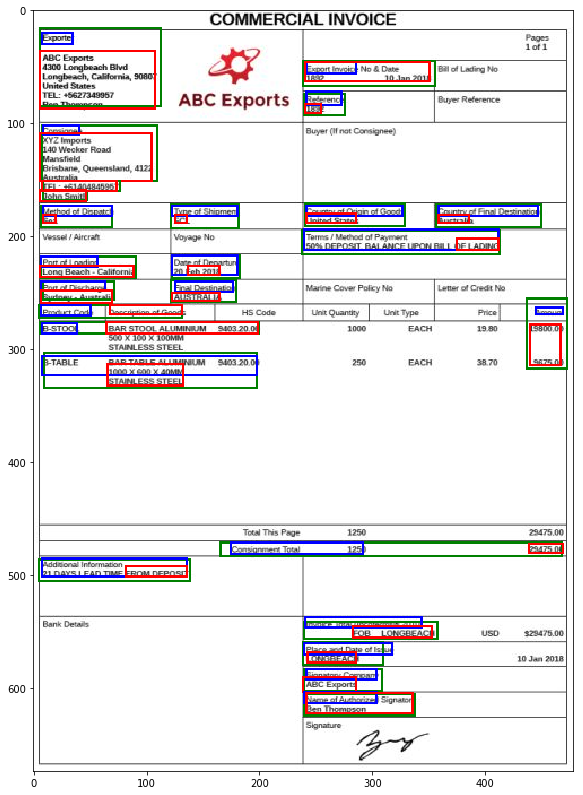

In [ ]:
# Visualize key value pairs to images, only support TIFF input.
with tf.gfile.Open(input_form_path, 'rb') as fid:
  img_data = Image.open(fid)

img = np.array(img_data.convert("RGB"))
draw_form_response_to_image(img, response_form)
print(img.shape)
plt.rcParams['figure.figsize'] = [14, 14]
plt.imshow(img)
plt.show()